In [1]:
import io, time, json
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sklearn
from tensorflow.keras.utils import to_categorical
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

C:\Users\josep\Anaconda3\lib\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
# Grabbing the nominees to get latest years data
def retrieve_html(url):
    """
    Return the raw HTML at the specified URL.

    Args:
        url (string): 

    Returns:
        result: dict, movie name as key, movie information as value
    """
    # remember to use browser header here, or cannot retrieve full data from the website
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    response = requests.get(url, headers = headers)
    html = response.content
    soup = BeautifulSoup(html,'lxml')

    result = {}
    for item in soup.find_all('div', {'class':'result-subgroup subgroup-awardcategory-chron'}):
        try:
            award_title = item.find('div',{'class':'result-subgroup-title'}).find('a',{'class':'nominations-link'}).contents[0]
            if award_title == 'ACTOR IN A LEADING ROLE':
                sub_groups = item.find_all('div',{'class':'result-details awards-result-actingorsimilar'})
                for sub in sub_groups:
                    sub_result = {}
                    film_title = sub.find('div',{'class':'awards-result-film-title'}).find('a',{'class':'nominations-link'}).contents[0]
                    is_winner = 1
                    actor = sub.find('div',{'class':'awards-result-nominationstatement'}).find('a',{'class':'nominations-link'}).contents[0]           
                    sub_result['film_title'] = film_title
                    sub_result['is_winner'] = is_winner
                    sub_result['actor'] = actor
                    result[film_title] = sub_result
        except Exception:
            pass
    return result

In [3]:
# data of year 2016
best_2016 = retrieve_html('http://awardsdatabase.oscars.org/Search/GetResults?query=%7B%22AwardShowFrom%22:89,%22Sort%22:%223-Award%20Category-Chron%22,%22Search%22:%22Basic%22%7D')

# data of year 2017
best_2017 = retrieve_html('http://awardsdatabase.oscars.org/Search/GetResults?query=%7B%22AwardShowFrom%22:90,%22Sort%22:%223-Award%20Category-Chron%22,%22Search%22:%22Basic%22%7D')

# data of year 2018
best_2018 = retrieve_html('http://awardsdatabase.oscars.org/Search/GetResults?query=%7B%22AwardShowFrom%22:91,%22Sort%22:%223-Award%20Category-Chron%22,%22Search%22:%22Basic%22%7D')
#best_2016

In [4]:
# Load Data
import numpy as np
import pandas as pd
# read from award
df_awards = pd.read_csv('database.csv', skiprows = 1, names=['year','ceremony','award','winner','name','film'])
df_movies = pd.read_csv('movies.csv')
df_credits = pd.read_csv('credits.csv')

In [5]:
# Testing
# Get list of awards to make sure we include all the right ones
#df_awards.award.unique()

In [6]:
#View data
#print(df_awards.head())
#print("-------------")
#print(df_movies.head())
#print("-------------")
#print(df_credits.head())

In [7]:
# append the data we scrapped to the df_awards
data=[]
for k,v in best_2016.items():
    row = []
    row.append(['2016', 89, 'Actor in a Leading Role', v['is_winner'], v['actor'], v['film_title']])
    data.append(row[0])

for k,v in best_2017.items():
    row = []
    row.append(['2017', 90, 'Actor in a Leading Role', v['is_winner'], v['actor'], v['film_title']])
    data.append(row[0])

for k,v in best_2018.items():
    row = []
    row.append(['2018', 91, 'Actor in a Leading Role', v['is_winner'], v['actor'], v['film_title']])
    data.append(row[0])

# pass the column name to the columns!!! Or there will be a runtime error
df_awards=df_awards.append(pd.DataFrame(data,columns=['year','ceremony','award','winner','name','film']),ignore_index=True)

#df_awards

In [8]:
# Data Manipulation
#Joining the credits and movies dataframes
if 'title' in df_credits.columns: 
  df_credits = df_credits.drop('title',axis=1) 
df_credits_movies = df_credits.set_index('movie_id').join(df_movies.set_index('id'))

#df_credits_movies.columns

In [9]:
#df_credits_movies.dtypes
# Reset the data types and get the earliest date of release_date
df_credits_movies['release_date'] = pd.to_datetime(df_credits_movies['release_date'])
#get the earliest release date from the dataset
min_year = min(df_credits_movies['release_date']) #1916-09-04
max_year = max(df_credits_movies['release_date']) #2017-02-03

In [10]:
# Select movies that are in 'Actor', 'Actor in a Leading Role' awards category -> df_picture_awards
#join df_credits_movies and df_awards by movie name (df_credits_movies.title = df_awards.movieName)
#before that, extract Directing from the df_awards
df_picture_awards = df_awards.loc[df_awards['award'].isin(['Actor', 'Actor in a Leading Role'])]
df_picture_awards.reset_index(drop = True, inplace = True)
df_credits_movies = df_credits_movies.loc[df_credits_movies['status'].isin(['Released'])]

#print("--------------")
#print(df_picture_awards.columns)
#print("--------------")
#print(df_credits_movies.columns)

In [11]:
# Replace all the null value in ‘winner’ column with 1
# df_picture_awards['winner'].isnull().sum()
df_picture_awards['winner'].fillna(1,inplace = True)
#df_picture_awards

In [12]:
# join df_picture_awards with df_credits_movies
#cleaning names/punctuation
import re
movieName = [re.sub(r'[^\w\s]','',x) for x in df_picture_awards['film'].str.lower().str.strip().values]
title = [re.sub(r'[^\w\s]','',x) for x in df_credits_movies['title'].str.lower().str.strip().values]
#then, change the title in the movie to lower case
df_picture_awards.loc[:,'movie_title'] = movieName #change the string to lower case
df_credits_movies.loc[:,'movie_title']= title
# check the dataframe, we can see the string in movie_title now is valid
#print(df_picture_awards.head())

In [13]:
# join the two tables, merge the data
df = df_picture_awards.merge(df_credits_movies, left_on='movie_title', right_on='movie_title', how='right')
df = df.reset_index(drop=True)
#drop the columns from award table
df.drop('homepage',axis = 1, inplace = True)
df.drop('year',axis = 1, inplace = True)
df.drop('award',axis = 1, inplace = True)
#df.drop('name',axis = 1, inplace = True)
df.drop('film',axis = 1, inplace = True)
df.drop('ceremony',axis = 1, inplace = True)
df['winner'].fillna(0,inplace=True) #fill NA with 0
#df

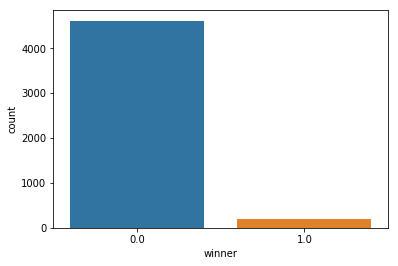

In [14]:
# We will choose the under-sampling by sampling from the 0-labeled data. 
# We need to first get a subset of nominated data, then sample from the non-nominated data, 
# and finally append the sampled data to the subset of nominated data.
sns.countplot(x='winner', data = df)


In [15]:
#Get the number of 0 labeled data, and the number of 1 labeled data
print(len(df.loc[df['winner'] == 0])) #4613
print(len(df.loc[df['winner'] == 1])) #189

4613
189


In [16]:
#balance the data
df_subset_0 = df.loc[df['winner'] == 0]
df_subset_1 = df.loc[df['winner'] == 1]

df_subset_0.drop('winner',axis=1,inplace=True)
df_subset_1.drop('winner',axis=1,inplace=True)

#sample with replacement
df_subset_0 = df_subset_0.sample(400) 
df_subset = pd.concat([df_subset_0,df_subset_1],ignore_index = True)
df_new = df_subset.merge(df_picture_awards, left_on = 'movie_title', right_on = 'movie_title', how = 'left')
df_new = df_new.fillna(0)

In [17]:
print(len(df_new))

603


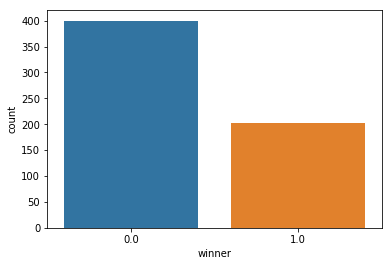

In [18]:
sns.countplot(x='winner', data = df_new)

In [19]:
#check number of null values in the dataset
#df_new.isnull().sum()

In [20]:
#Exploratory Data Analysis

# check the data types and select numeric variables
#df_new.dtypes

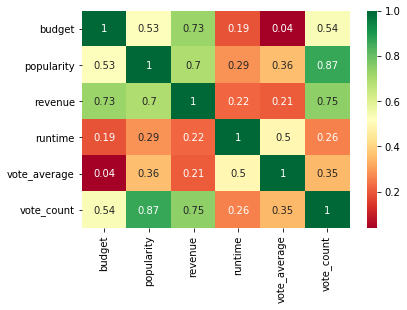

In [21]:
# correlation analysis
g = sns.heatmap(df_new[['budget','popularity','revenue','runtime','vote_average','vote_count']].corr(),cmap='RdYlGn',annot=True)

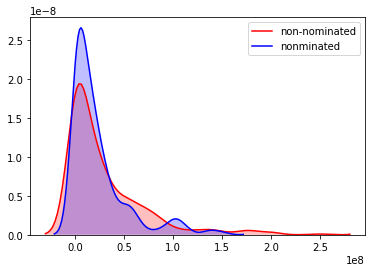

In [22]:
# Density Curve
# budget
budget0 = df_new[df_new['winner'] == 0]['budget']
budget1 = df_new[df_new['winner'] == 1]['budget']

g = sns.kdeplot(budget0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(budget1, legend = True, shade=True, color='b', label = 'nonminated')

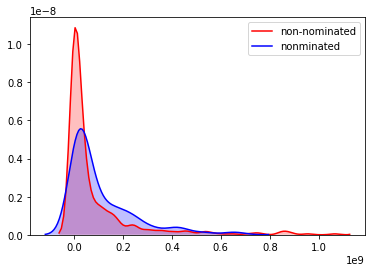

In [23]:
# revenue
# density curve
revenue0 = df_new[df_new['winner'] == 0]['revenue']
revenue1 = df_new[df_new['winner'] == 1]['revenue']

g = sns.kdeplot(revenue0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(revenue1, legend = True, shade=True, color='b', label = 'nonminated')

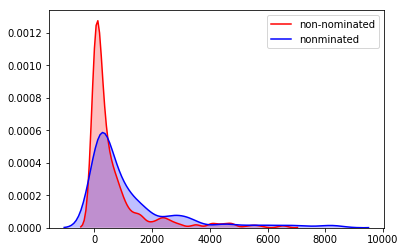

In [24]:
# vote count
vc0 = df_new[df_new['winner'] == 0]['vote_count']
vc1 = df_new[df_new['winner'] == 1]['vote_count']

g = sns.kdeplot(vc0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(vc1, legend = True, shade=True, color='b', label = 'nonminated')

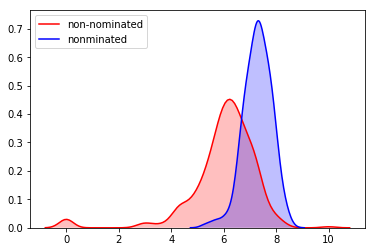

In [25]:
# vote average
va0 = df_new[df_new['winner'] == 0]['vote_average']
va1 = df_new[df_new['winner'] == 1]['vote_average']

g = sns.kdeplot(va0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(va1, legend = True, shade=True, color='b', label = 'nonminated')

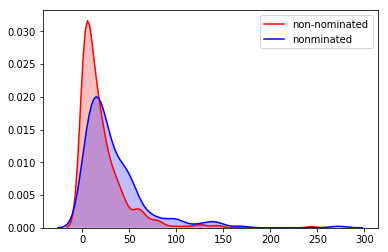

In [26]:
# popularity
popularity0 = df_new[df_new['winner'] == 0]['popularity']
popularity1 = df_new[df_new['winner'] == 1]['popularity']

g = sns.kdeplot(popularity0, legend = True, shade=True, color='r',label = 'non-nominated')
g = sns.kdeplot(popularity1, legend = True, shade=True, color='b', label = 'nonminated')

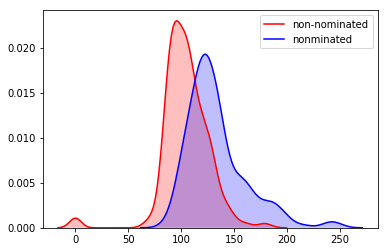

In [27]:
#runtime
runtime0 = df_new[df_new['winner'] == 0]['runtime']
runtime1 = df_new[df_new['winner'] == 1]['runtime']

g = sns.kdeplot(runtime0, legend = True, shade=True, color='r', label = 'non-nominated')
g = sns.kdeplot(runtime1, legend = True, shade=True, color='b', label = 'nonminated')

In [28]:
#genres
#clean the data
genres_name0 = {}
genres_name1 = {}
genres_set = set()
for i in range(len(df_new)):
    genres = json.loads(df_new.loc[i,'genres'])
    for it in genres:
        genres_set.add(it['name'])
        if df_new.loc[i,'winner'] == 0:
            if it['name'] not in genres_name0:
                genres_name0[it['name']] = 1
            else:
                genres_name0[it['name']] += 1
        if df_new.loc[i,'winner'] == 1:
            if it['name'] not in genres_name1:
                genres_name1[it['name']] = 1
            else:
                genres_name1[it['name']] += 1

genres_array0=[]
genres_array1=[]
for g in genres_set:
    if g in genres_name0:
        genres_array0.append(genres_name0[g])
    else:
        genres_array0.append(0)
    if g in genres_name1:
        genres_array1.append(genres_name1[g])
    else:
        genres_array1.append(0)


        
genres_all = []
genres_all.append(np.array(genres_array0)/sum(genres_array0))
genres_all.append(np.array(genres_array1)/sum(genres_array1))

In [58]:
df_genres = pd.DataFrame(genres_all, columns=list(genres_set))
df_genres[["Adventure","Fantasy","Animation","War","Music","Documentary","Foreign","Drama","Horror","Family","Crime","Mystery","Science Fiction","History","Action","Comedy","Romance","Western","Thriller"]]


,Adventure,Fantasy,Animation,War,Music,Documentary,Foreign,Drama,Horror,Family,Crime,Mystery,Science Fiction,History,Action,Comedy,Romance,Western,Thriller
0,0.070336,0.040775,0.018349,0.009174,0.015291,0.008155,0.002039,0.171254,0.047910,0.047910,0.041794,0.023445,0.050968,0.015291,0.087666,0.164118,0.088685,0.005097,0.090724
1,0.031250,0.008929,0.000000,0.060268,0.031250,0.000000,0.000000,0.421875,0.002232,0.011161,0.053571,0.015625,0.006696,0.091518,0.031250,0.055804,0.109375,0.020089,0.049107


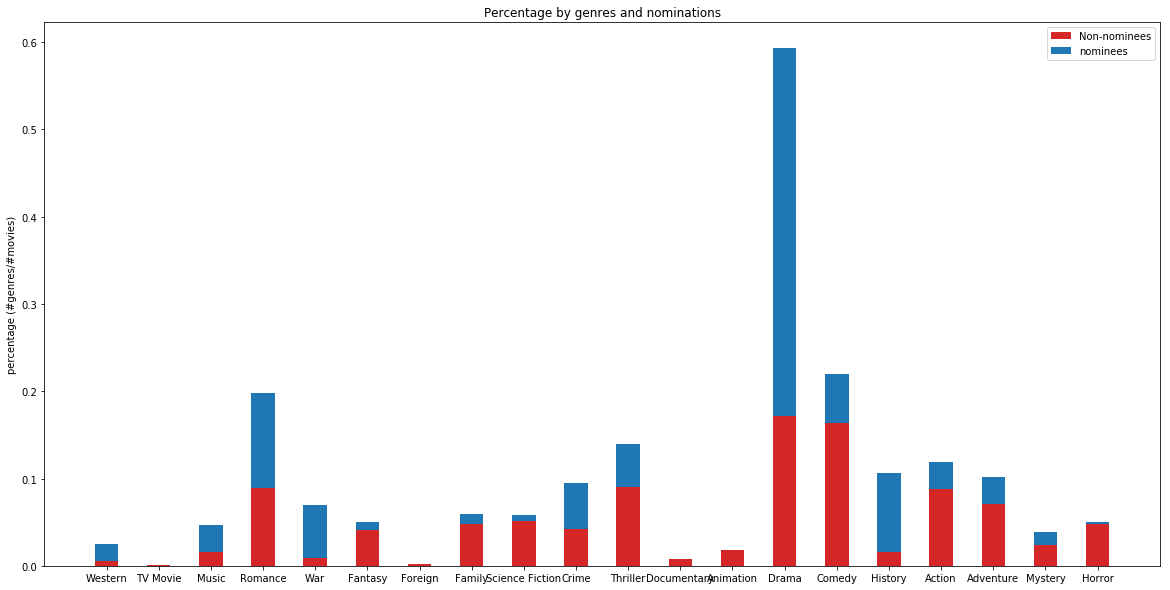

In [30]:
# draw stacked bar chart
N = len(df_genres.columns)
ind = np.arange(N)
width = 0.45

plt.figure(figsize=(20,10))
p1 = plt.bar(ind, df_genres.loc[[0]].values[0], width, color='#d62728')
p2 = plt.bar(ind, df_genres.loc[[1]].values[0], width, bottom=df_genres.loc[[0]].values[0])


plt.ylabel('percentage (#genres/#movies)')
plt.title('Percentage by genres and nominations')
plt.xticks(ind,df_genres.columns)
plt.legend((p1[0],p2[0]),('Non-nominees','nominees'))

In [31]:
# Feature Engineering
# Since many columns such as “crew”, “cast” contain information in json format, we need to extract useful information from the columns and then perform one hot encoding.
# We will transform our dataset into a all numeric matrix so that we can feed the data into our machine learning model.
# To look at the structure of column (eg.”cast”), we can use: df.loc[0,’cast’]
import json
def feature_engineering(column_name, df, json_name):
    """
    Args:
        column_name: the column name in the dataframe that contains a json file that needs to conduct feature engineering on
        df: dataframe that perform feature engineering on
        json_name: name in the json file that we want to extract
    
    Returns: new dataframe after feature engineering
    """
    
    name = {}

    for item in df[column_name]:
        group = json.loads(item)
        for it in group:
            if it[json_name] not in name:
                name[it[json_name]] = 1
            else:
                name[it[json_name]] += 1
    
    final = {}
    index = 0
    for k,v in name.items():
        if v > 1:
            final[k] = index
            index += 1
    np_item = np.zeros((len(df),len(final)))
    item_dict = {}
    row = 0
    for item in df[column_name]:
        group = json.loads(item)
        for it in group:
            if it[json_name] in final:
                index = final[it[json_name]]
                np_item[row][index] = 1
        row += 1

    df_item = pd.DataFrame(np_item, columns = list(final.keys()))
    df_output = pd.concat([df,df_item],axis = 1)
    
    return df_output

In [32]:
df2 = feature_engineering("cast", df_new, "name")
df2 = df2.drop('cast', axis = 1) #drop the column after feature engineering

In [33]:
# director
crew_name = {}

for item in df2['crew']:
    crew = json.loads(item)
    for it in crew:
        if it['job'] == 'Director':
            if it['name'] not in crew_name:
                crew_name[it['name']] = 1
            else:
                crew_name[it['name']]+=1


# set the appear tims for actors
final_crew = {}
index = 0
for k,v in crew_name.items():
    if v > 0:
        final_crew[k] = index
        index += 1
# print(len(final_crew))

np_crew = np.zeros((len(df2), len(final_crew)))
row = 0
for item in df2['crew']:
    crew = json.loads(item)
    for it in crew:
        if it['job'] == 'Director':
            if it['name'] in final_crew:
                index = final_crew[it['name']]
                np_crew[row][index] = 1
    row += 1

df_crew = pd.DataFrame(np_crew, columns = list(final_crew.keys()))
            
df3 = pd.concat([df2, df_crew], axis = 1)
# print(df.shape)

In [34]:
df3=df3.drop(['crew'],axis=1)
#genres
df4 = feature_engineering("genres", df3, "name")
df4 = df4.drop(['genres'], axis = 1)
#keywords
df5 = feature_engineering('keywords', df4, 'name')
df5 = df5.drop(['keywords'], axis = 1)
#production_companies
df6 = feature_engineering('production_companies',df5,'name')
df6 = df6.drop(['production_companies'],axis=1)
#production_countries
df7 = feature_engineering('production_countries',df6,'name')
df7 = df7.drop(['production_countries'],axis=1)
#spoken_languages
df8 = feature_engineering('spoken_languages',df7,'iso_639_1')
df8 = df8.drop(['spoken_languages'],axis=1)


In [35]:
#df8

In [36]:
# drop the columns not used
df_clean = df8.drop(["film","name_y","name_x","overview","original_title","original_language","tagline","status","release_date","award", 'movie_title', 'title'],axis=1)

In [37]:
#df_clean.columns

In [38]:
# Model Training
# split
X = df_clean[df_clean.columns.difference(['winner'])]
# X = StandardScaler().fit_transform(X)
y = df_clean['winner']
from sklearn.model_selection import train_test_split
# test_size: what proportion of original data is used for test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/5.0, random_state=0)

In [39]:
#test: ValueError: could not convert string to float: 'devil'
# how is there 'devil' if i'm getting the info from the 'winner' column?
#df_clean['winner'].values -- nothing but 0s and 1s
#X_train.columns.tolist() #looks like it...

In [40]:
from sklearn.decomposition import PCA
pca = PCA(0.95)
fit = pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
# pca = PCA(n_components = 3)
# fit = pca.fit_transform(X)
# fit2 = pca.fit(X)
# print("Explained Variance: %s" % pca.explained_variance_ratio_) 
# print(fit)

In [41]:
from sklearn.linear_model import LogisticRegression

# all parameters not specified are set to their defaults
# For small datasets, ‘liblinear’ is a good choice
logisticRegr = LogisticRegression(solver = 'liblinear')
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
# Predict for One Observation
predicted = logisticRegr.predict(X_test)
print(logisticRegr.predict(X_test))
print(y_test.index)
# df8['movie_title'][y_test.index]

[0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.
 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 1.]
Int64Index([272,  52, 479, 194, 345, 343, 243, 462, 422, 354,
            ...
             75,  10, 443, 242, 547, 391, 600, 367, 247, 493],
           dtype='int64', length=121)


In [43]:
logisticRegr.score(X_test, y_test) # 0.6694214876033058

0.6198347107438017

In [44]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
sensitivity = tp/(tp+fn)
print(sensitivity) # 0.2926829268292683

0.2926829268292683


In [45]:
# Improvement: Cross Validation
# 3-fold Cross validation
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3)
sumAccuracy = []
for train,test in skf.split(X,y):
#     logisticRegr.fit(df_clean.iloc[train][], )
    df_train = df_clean.iloc[train]
    df_test = df_clean.iloc[test]
    train_X = df_train[df_clean.columns.difference(['winner'])]
    train_y = df_train['winner']
    test_X = df_test[df_clean.columns.difference(['winner'])]
    test_y = df_test['winner']
    logisticRegr.fit(train_X, train_y)
    sumAccuracy.append(logisticRegr.score(test_X, test_y))
avg = np.mean(sumAccuracy)
print(avg) # 0.6826185081194688
#     print(df_clean.iloc[train,df_clean.columns.difference(['winner'])])

0.7059676863208709
